# ДЗ 2

In [32]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Для начала скачаем данные. Годятся вообще любые изображения, не обязательно из какого-то изветсного датасета. Этой командой можно скачать и распакавать фотографии с одной школы по программированию, проходившей этим летом.

In [9]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar

--2022-03-19 14:56:16--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  6.05MB/s    in 13s     

2022-03-19 14:56:29 (5.16 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



Есть два подхода к работе с данными:

1. Сначала преобразовать все имеющиеся данные к виду, который принимает нейросеть (сразу к тензорам одинакового размера).
2. Хранить сырые данные и преобразование препроцессинга (функцию) и собирать батчи на лету.

Если это не что-то совсем простое, то второй вариант предпочтительнее, так как он не требует дополнительной памяти (датасеты могут быть большими), времени на векторизацию датасета, а так же сбор батча «на лету» позволяет там же делать аугментацию.

Для этого в PyTorch есть две абстракции: `Dataset` и `DataLoader`.

`Dataset` — абстрактный класс, от которого нужно отнаследовать класс датасета, который мы напишем. В нём должны быть определён конструктор (в нём обычно загружаются в память сырые данные, которые лежат где-то на диске, а также сохраняется какая-нибудь другая информация), метод `__len__` (должен вернуть размер датасета) и `__getitem__`, который должен по номеру сэмпла вернуть его в виде тензора (возможно, произведя какой-нибудь препроцессинг).

In [10]:
# tqdm -- это маленькая библиотечка для прорисовывания progress bar-ов прямо в питоне

from tqdm import tqdm
from time import sleep
import os
from PIL import Image

In [11]:
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

Чтобы подавать картинки на вход нейросети, нужно их перевести в тензоры, причём одинакового размера.

In [12]:
from torchvision.transforms.transforms import GaussianBlur
transform_all = transforms.Compose([
    # вырежем случайный квадратик
    transforms.RandomResizedCrop(128),
    # горизонтально перевернем -- изображение останется валидным
    transforms.RandomHorizontalFlip(),
    # что бы ещё поделать, чтобы увеличить размер датасета?
    # ...
   # transforms.RandomRotation((-5, 5), resample=Image.BILINEAR),

    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)
    # минутка эволюционной биологии: как вы думаете, почему коэффициенты именно такие?

Здесь `transform_all` и `to_grayscale` являются функциями (формально, первый является функтором), которые мы передадим дальше в `DataLoader`, который оборачивает датасет и позволяет итерироваться по нему по батчам, а также реализует разные полезные функции вроде перемешивания данных после каждой эпохи.

In [13]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 655.94it/s]


In [14]:
len(dataset)

1015

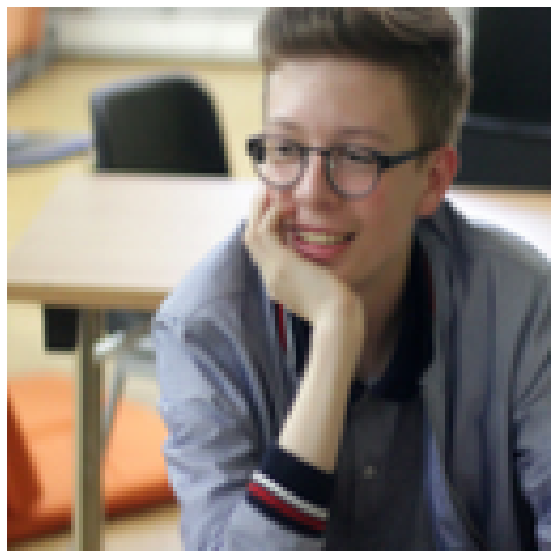

In [33]:
plt.figure(figsize=(10,10))
img_pred = to_numpy_image(dataset[0][1].view(3, 128, 128))
plt.axis('off')
plt.imshow(img_pred.reshape((128, 128, 3)))

**Skip-connection**. Иногда бывает полезно присоединить к выходу какого-то слоя его вход, чтобы следующий получил такую же, неизменённую копию. Здесь мы поступим именно так: подадим исходное черно-белое изображение в какую-то одну часть сети, которая сконцентрируется на определении цвета, а затем припишем последним слоем её выход и отправим дальше другому модулю, который уже раскрасит это исходное изображение. От простоты `nn.Sequential`, правда, уже придётся отказаться, и нужно написать свой класс.

In [16]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.BatchNorm2d(channels_out),
        # nn.Dropout(),
        nn.ReLU(),
        # nn.BatchNorm(),
    )

In [17]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential( #1, 128, 128
            Block(1, 64),         #64, 128, 128
            nn.MaxPool2d((2, 2)), #64, 64, 64
            Block(64, 128),       #128, 64, 64
            nn.MaxPool2d((2, 2)),  #128, 32, 32
            Block(128, 256),
            Block(256, 256),
            Block(256, 256),
            nn.Upsample(scale_factor=2), # 256, 64, 64
            Block(256, 128), # 128, 64, 64
            nn.Upsample(scale_factor=2),  #128, 128, 128
            Block(128, 64),       #64, 128, 128

        )
         
        self.postconcat = nn.Sequential(         # эту сетку можно особо не увеличивать - она не должна быть очень умной
            nn.Conv2d(65, 32, (3, 3), padding=1),# подумайте, откуда у автора тут 65
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.preconcat(x)
        # исходное чб изображение -- просто дополнительным слоем
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

Дальше как обычно:

In [ ]:
num_epochs = 100
lr = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss()  # тут можно поиграться с лоссами

In [34]:
def print_images(lst):
    for t in lst:
          img_gray, img_true = dataset[t]
          img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
          img_pred = to_numpy_image(img_pred)
          # теперь это numpy-евский ndarray размера (128, 128, 3)
          plt.figure(figsize=(10,10))
          
          plt.subplot(141)
          plt.axis('off')
          plt.set_cmap('Greys')
          plt.imshow(img_gray.reshape((128, 128)))

          plt.subplot(142)
          plt.axis('off')
          plt.imshow(img_pred.reshape((128, 128, 3)))

          plt.subplot(143)
          plt.axis('off')
          plt.imshow(to_numpy_image(img_true))
          
          plt.show()

In [ ]:
history = []
for epoch in range(num_epochs):
    for x, y in loader:
        # теперь сами:
        # 0. распакавать данные на нужное устройство
        x = x.to(device)
        y = y.to(device)
        # 1. сбросить градиент
        optimizer.zero_grad() 
        # 2. прогнать данные через сеть
        colorized = model(x)
        # 3. посчитать loss
        loss = criterion(colorized, y)
        # 4. залоггировать его куда-нибудь
        history.append(loss.item())
        # 5. сделать .backward()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        # 6. optimizer.step()
        optimizer.step()
    # сохраняю модельку, чтобы она не потерялась, если коллаб упал
    if epoch % 10 == 0:
        torch.save(model, 'drive/MyDrive/model.pth')
    print(history[-1])

    # (7. вывести пример колоризации -- см код ниже)
    #print_images([0, 197, 550])

0.040413931012153625
0.043178752064704895
0.04660767316818237
0.037429165095090866
0.04403920844197273
0.03778824582695961
0.03707025572657585
0.042470403015613556
0.04114711657166481
0.041425663977861404
0.0438663624227047
0.041063208132982254
0.044175971299409866
0.041064053773880005
0.04502440616488457
0.03897969052195549
0.041626717895269394
0.04130781069397926
0.04060140624642372
0.04115236550569534
0.04225748032331467
0.03837710618972778
0.03958771005272865
0.0385427363216877
0.04182147979736328
0.04212716221809387
0.04568314179778099
0.040871020406484604
0.0396486259996891
0.04381823539733887
0.04285696521401405
0.039761848747730255
0.039232853800058365
0.043739497661590576
0.04644334316253662
0.043595701456069946
0.04278060793876648


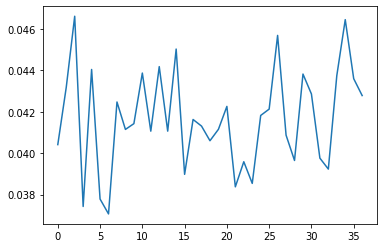

In [113]:
plt.plot(history) # я все прошлые лоссы потерял, так что тут последние 36
plt.show()

In [20]:
if torch.cuda.is_available():
  model = torch.load('drive/MyDrive/model.pth')
else:
  model = torch.load('drive/MyDrive/model.pth', map_location=torch.device('cpu'))

В подобных нечётко поставленных задачах важно смотреть не цифры, а на реальные примеры.


In [21]:
def to_numpy_image(img):
    # tl;dr: PyTorch хочет (3, 128, 128), а plt.imshow хочет (128, 128, 3)
    # есть два популярных формата для цветных картинок:
    #  1. где размерность, соответствующая каналам, идёт последней
    #  2. где размерность, соответствующая каналам, идёт первой
    # при работе с нейросетями удобен первый подход -- так запрашиваемая
    # при вычислениях память идёт последовательно, и из-за кэширования
    # операции свёртки работают быстрее
    # второй подход удобнее при уже работе с устройством, которое эти картинки показывает
    # -- удобно на три лампочки послать сразу три последовательно идущих байта
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

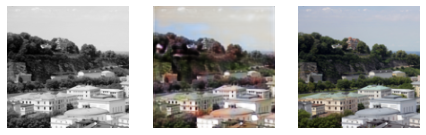

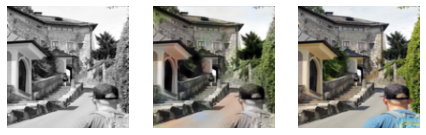

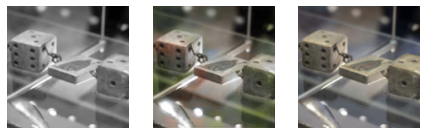

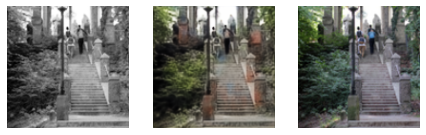

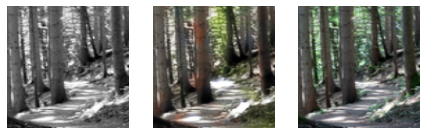

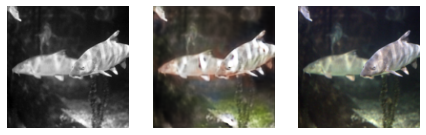

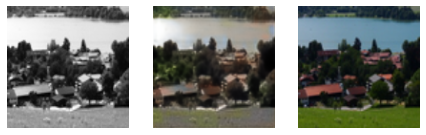

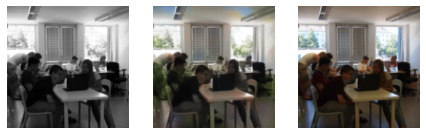

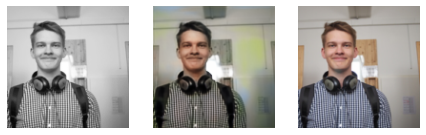

In [111]:
lst = [73, 81, 86, 93, 628, 787, 882, 884, 933]
print_images(lst)

## *Тизер: adversarial loss

У нашего подхода к колоризации есть одна весьма существенная проблема: непонятно, как определять функцию потерь. Выясняется, что l1 или l2 в некоторых случаях даже являются принципиально неправильным выбором. Представьте, что у нас есть датасет фотографий с летнего лагеря, в котором все люди ходят в футболках двух разных цветов — например, красного и синего — интенсивность которых одинакова и неотличима на черно-белых версиях. Тогда наш лосс заставит сеть выбирать что-то «по середине» (в случае с l2 это будет среднее, а с l1 медиана), и, скорее всего, она сгенерирует что-то серое, в то время как она должна с какой-то вероятностью сгенерировать явно красную или явно синюю футболку.

Решение в следующем: выход (колоризованное изображение) кормить в другую сеть, которая учится определять «правдоподобность» раскраски. Помимо восстановления изображения с точки зрения какой-то меры близости, сети-генератору (колоризатору) нужно ещё и обмануть сеть-дискриминатор, а сети-дискриминатору нужно наоборот, учиться отличать настоящую колоризацию от нашей.

Подобные схемы с двумя состязяющимися сетями называют GAN-ам (Generative Adversarial Networks), о которых мы поговорим через занятие.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
